# Image classification of six-sided dice
### Using Keras and a LeNet-5 inspired Convolutional Neural Network

This part of the project made use of Mario Lurig's dice image dataset, linked at the bottom of this cell. In this project, I focus on only six-sided dice, but the dataset includes many different kinds of dice (d4, d8, d12, etc.).

The dice image dataset (as published on kaggle) was unlabled. However, the ordering of the images made it relatively quick to label - there are 100-200 images in a row of the same die (from different angles). I was able to label groups of images in bulk, using an open excel sheet to extend the same label across several hundred images at a time (took 10 minutes, tops). I've provided these labels in `data/kaggle_labels/{test/train}.txt`, which are split identically to the test/train split on kaggle. The files have two columns: (1) filename, identical to the filename on kaggle; and (2) label, an integer between 1 and 6.

https://www.kaggle.com/ucffool/dice-d4-d6-d8-d10-d12-d20-images

# Download Kaggle Stuff

In [1]:
# Go to Kaggle -> Account Settings -> API -> Create new Token -> Download the generated JSON

# Upload kaggle.json to Google Colab; otherwise put it into current directory
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marckohaupt","key":"31ca04a4ae587ed7010ff4b39f0a5996"}'}

In [2]:
! pip install -q kaggle

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list
! kaggle datasets download ucffool/dice-d4-d6-d8-d10-d12-d20-images
! mkdir -p dice-images
! unzip dice-d4-d6-d8-d10-d12-d20-images.zip -d dice-images

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: dice-images/dice/train/d6/d6_top_0782.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0784.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0785.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0786.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0787.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0788.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0789.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0790.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0792.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0793.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0794.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0795.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0796.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0797.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0798.jpg  
  inflating: dice-images/dice/train/d6/d6_top_0800.jpg  
  inflating: dice-ima

# generate images from movie clips

In [3]:
# recode files
#for i in *.MTS; do ~/_Scripts/Media-Conversion/encode-DSLR-movies.sh "$i"; done
# upload them into ./dice-videos
# ...

In [4]:
sh = """
cd dice-videos
mkdir -p pictures
for i in *.mkv; do
  echo Processing "$i"
  #directory=$(echo "$i" | awk '{print $1;}')
  directory=$(echo "$i" | awk '{split($0,a,"-"); print a[1]}')
  mkdir -p pictures/$directory
  ffmpeg -i "$i" -r 50 -filter:v "crop=1080:1080:450:0"  "pictures/$directory/image-%3d.jpeg"
done
"""
with open('extract-pictures-from-videos.sh', 'w') as file:
  file.write(sh)

!bash extract-pictures-from-videos.sh

Processing 1-00014.MTS.h264-medium.acc-default.mkv
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-lib

In [5]:
# !apt-get install -y imagemagick

# sh = """
# cd dice-videos/pictures/
# for dir in *; do
#   echo Processing $dir
#   cd $dir
#   for i in *; do
#     convert $i -resize 64x64 $i.new
#     mv $i.new $i
#   done
#   cd ..
# done
# """
# with open('rename-files.sh', 'w') as file:
#   file.write(sh)

# !bash rename-files.sh

In [6]:
sh = """
cd dice-videos/pictures/
for dir in *; do
  echo Processing $dir
  cd $dir
  for i in *; do
    sum=$(cat "$i" | md5sum)
    #echo mv "$i" "${sum%% *}.${i##*.}"
    mv "$i" "${sum%% *}.${i##*.}"
  done
  cd ..
done
"""
with open('rename-files.sh', 'w') as file:
  file.write(sh)

!bash rename-files.sh

Processing 1
Processing 2
Processing 3
Processing 4


In [7]:
sh = """
cd dice-videos/pictures/
mkdir -p ../all_pictures
rm ../labels.txt

for dir in *; do
  cd $dir
  for i in *; do
    echo "$i,$dir" >> ../../labels.txt
    cp $i ../../all_pictures/
    cp $i ../../../dice-images/dice/train/d6/
  done
  cd ..
done

cp ../labels.txt ../../tensorflow-dice-detection/data/kaggle_labels/train.txt
"""
with open('sort-for-kaggle.sh', 'w') as file:
  file.write(sh)

!bash sort-for-kaggle.sh

rm: cannot remove '../labels.txt': No such file or directory
cp: cannot create regular file '../../tensorflow-dice-detection/data/kaggle_labels/train.txt': No such file or directory


# start

In [8]:
# Clone git repository; works in Google Colab
! git clone https://github.com/debuglevel/tensorflow-dice-detection

Cloning into 'tensorflow-dice-detection'...
remote: Enumerating objects: 429, done.
remote: Counting objects: 100% (429/429), done.
remote: Compressing objects: 100% (395/395), done.
remote: Total 429 (delta 85), reused 321 (delta 18), pack-reused 0
Receiving objects: 100% (429/429), 6.93 MiB | 11.70 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
import tensorflow as tf
from tensorflow.python.framework import ops
from PIL import Image
import glob, os
%matplotlib inline

In [10]:
# path to local image directory, change as you see fit
LOCAL_IMAGE_DIR = './dice-images/dice'

# path to local tensorflow-dice-detection repository
WORKING_DIR = './tensorflow-dice-detection' # on Google Colab
#WORKING_DIR = './' # inside local git repo
DATA_DIR = WORKING_DIR+'/data/kaggle_labels'

In [11]:
# list of image filenames in the training set
data_train = np.genfromtxt(DATA_DIR+'/train.txt',
                           names='fnames, Y',
                          dtype=None, delimiter=',', encoding=None)

# list of image filenames in the test set
data_test = np.genfromtxt(DATA_DIR+'/test.txt',
                          names='fnames, Y',
                          dtype=None, delimiter=',', encoding=None)

#print(data_train)

### Example of what the data looks like

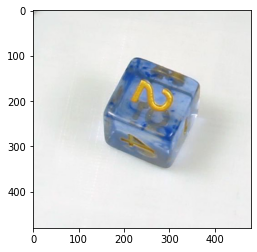

In [12]:
# grab a random image from the list of filenames
randomFile = np.random.choice(data_train['fnames'], size=1)
# pull full path for local image directory
testFile = '/'.join([LOCAL_IMAGE_DIR, 'train', 'd6', randomFile[0]])
# display image
image = mpimg.imread(testFile)
plt.imshow(image)

# Resize images
I ran this model from my macbook, which is not particularly computationally beefy. To accomodate the limited memory, I resized all of the kaggle images (408 x 408) to 64x64 pixels, and then stored the 64x64x3 image arrays in hdf5 files, along with a one-hot classification.

In [13]:
size = 64, 64

def to_thumbnail(infile):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile)
    im.thumbnail(size)
    im.save(file + ".thumbnail", "PNG")

for infile in glob.glob(LOCAL_IMAGE_DIR+"/train/"+"d6/"+"*.jp*"):
    to_thumbnail(infile)
    # file, ext = os.path.splitext(infile)
    # im = Image.open(infile)
    # im.thumbnail(size)
    # im.save(file + ".thumbnail", "PNG")

#for infile in glob.glob(LOCAL_IMAGE_DIR+"/test/"+"d6/"+"*.jpg"):    
for infile in glob.glob(LOCAL_IMAGE_DIR+"/valid/"+"d6/"+"*.jp*"):
    to_thumbnail(infile)
    # file, ext = os.path.splitext(infile)
    # im = Image.open(infile)
    # im.thumbnail(size)
    # im.save(file + ".thumbnail", "PNG")

### Generate h5 files for train/test sets

In [14]:
def quick_one_hot(Y_orig, labels):
    '''
    Y_orig is array of shape (m_examples,)
    labels is unique array of values in Y_orig
        of shape (num_labels)
    Output: array of shape (m, num_labels)
        >>> labels 1-6 correspond to index 0-5 (0-index)
    Note: you can also use 
          keras.utils.to_categorical(y, num_classes)
    '''
    m = Y_orig.shape[0]
    num_labels = len(labels)
    # broadcasting
    Y_labs = np.ones((m, num_labels))*Y_orig[:,None]
    Y_inds = np.arange(1, num_labels+1)[None,:]*np.ones((m, num_labels))
    Y = (Y_inds == Y_labs)*1. # m_test x num_labels
    return Y

In [15]:
def create_h5_output(data, subdir='train', outfile = 'train.txt'):
    '''
    input: data (np.recarray of image names, labels)
           subdir ('train', or 'test')
           outfile for hdf5 file ('/path/to/train.hdf5')
    '''
    labels = np.unique(data['Y'])
    numb_labels = len(labels)
    m = len(data['fnames'])
    
    # grab list of images
    fileList = np.array(['/'.join([LOCAL_IMAGE_DIR,
                                   subdir,
                                   data['fnames'][i]])
                         for i in range(m)])
    # initialize output
    X = np.zeros((m, 64, 64, 3))

    for i, file_ in enumerate(fileList):
        img = Image.open(file_.replace('.jpg', '.thumbnail'))
        X[i] = np.asarray(img)/255.
    # print results
    print('The data set has shape {0}'.format(X.shape))
    # check shape of one-hot
    Y = quick_one_hot(data['Y'], labels)
    print('The output is shape {0}'.format(Y.shape))
    
    # prepare hdf5 file
    hf = h5py.File(outfile, 'w')
    # add X, Y, use subdir to name
    hf.create_dataset('X_{}'.format(subdir),
                      data=X, compression='gzip')
    hf.create_dataset('Y_{}'.format(subdir),
                      data=Y, compression='gzip')
    # close file to write
    hf.close()
    print('Wrote to {}'.format(outfile))
    return

In [16]:
# train data
create_h5_output(data_train, subdir='train'+"/d6",
                 outfile = LOCAL_IMAGE_DIR+'/d6_train.h5')

The data set has shape (4046, 64, 64, 3)
The output is shape (4046, 6)
Wrote to ./dice-images/dice/d6_train.h5


In [17]:
# test data
#create_h5_output(data_test, subdir='test'+"/d6",

create_h5_output(data_test, subdir='valid'+"/d6",
                 outfile = LOCAL_IMAGE_DIR+'/d6_test.h5')

The data set has shape (578, 64, 64, 3)
The output is shape (578, 6)
Wrote to ./dice-images/dice/d6_test.h5


## Read in train/test data

In [18]:
# training set
with h5py.File(LOCAL_IMAGE_DIR+'/d6_train.h5', 'r') as f:
    X_train = np.array(f['X_train']["d6"][:])
    Y_train = np.array(f['Y_train']["d6"][:])

# test set
with h5py.File(LOCAL_IMAGE_DIR+'/d6_test.h5', 'r') as f:
    X_test = np.array(f['X_valid']["d6"][:])
    Y_test = np.array(f['Y_valid']["d6"][:])

# useful numbers
m_test, n_H, n_W, n_C = X_test.shape
m_train, n_y = Y_train.shape

print(f'Number of training examples: {m_train}')
print(f'Number of test examples: {m_test}')
print(f'Dimensions of images: {n_H} x {n_W} x {n_C}')
print(f'Number of output classes: {n_y}')

Number of training examples: 4046
Number of test examples: 578
Dimensions of images: 64 x 64 x 3
Number of output classes: 6


y = [0. 0. 1. 0. 0. 0.]


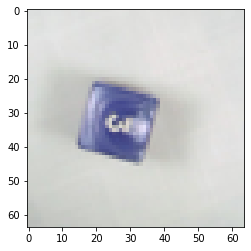

In [19]:
# Example of resized image
index = np.random.choice(X_train.shape[0],1)[0]
plt.imshow(X_train[index])
print ("y = " + str(np.squeeze(Y_train[index])))

## Set up framework for NN

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

I'm using a simple convolutional neural network architecture, inspired by the LeNet-5 model, which was used to recognize handwritten digits. The model is structured as follows:
1. Convolution layer
  - ReLU activation
  - 8 filters, 4x4 kernel
2. Pooling layer
  - max pooling
3. Convolution layer
  - ReLU activation
  - 16 filters, 2x2 kernel
4. Pooling layer
  - max pooling
5. Fully connected layer
  - softmax with 6 outputs

In [21]:
# fix model structure
batch_size=64
epochs=400
#epochs=100
num_classes = n_y
nfilters = [8, 16]
kernel_sizes = [(4,4), (2,2)]

# relevant hyperparameters (default for Adam optimizer)
learning_rate=0.0001
decay=1e-6

In [22]:
model = Sequential()

# CONV1 (ReLU) > POOL1
model.add(Conv2D(nfilters[0], kernel_sizes[0], # 8 filters, 4x4
                 strides=(1,1),
                 padding='same', 
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(8,8),
                       strides=(8,8),
                       padding='same'))
# CONV2 (ReLU) > POOL2
model.add(Conv2D(nfilters[1], kernel_sizes[1], # 16 filters, 2x2
                 strides=(1,1),
                 padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4),
                       strides=(4,4),
                       padding='same'))

# Fully connected layer with softmax
model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# We will use the Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=decay)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Optimize

In [ ]:
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test),
          shuffle=True)

Epoch 1/400
64/64 [==============================] - 9s 119ms/step - loss: 1.8208 - accuracy: 0.1434 - val_loss: 1.7955 - val_accuracy: 0.1869
Epoch 2/400
64/64 [==============================] - 7s 116ms/step - loss: 1.7828 - accuracy: 0.2215 - val_loss: 1.7734 - val_accuracy: 0.2457
Epoch 3/400
64/64 [==============================] - 7s 116ms/step - loss: 1.7665 - accuracy: 0.2659 - val_loss: 1.7609 - val_accuracy: 0.2889
Epoch 4/400
64/64 [==============================] - 7s 116ms/step - loss: 1.7547 - accuracy: 0.2714 - val_loss: 1.7500 - val_accuracy: 0.2716
Epoch 5/400
64/64 [==============================] - 7s 117ms/step - loss: 1.7435 - accuracy: 0.2726 - val_loss: 1.7386 - val_accuracy: 0.2734
Epoch 6/400
64/64 [==============================] - 7s 116ms/step - loss: 1.7298 - accuracy: 0.2383 - val_loss: 1.7237 - val_accuracy: 0.2301
Epoch 7/400
64/64 [==============================] - 7s 116ms/step - loss: 1.7159 - accuracy: 0.3047 - val_loss: 1.7114 - val_accuracy: 0.3201

In [ ]:
# Score trained model.
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

### Save trained model

In [ ]:
save_dir = LOCAL_IMAGE_DIR+'/models/'
model_name = 'keras_2CONV_trained_model.h5'

In [ ]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
# TODO: does not work

# # Plot training & validation accuracy values
# plt.plot(model.history.history['accuracy'])
# plt.plot(model.history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(model.history.history['loss'])
# plt.plot(model.history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

## Load previously saved model

In [ ]:
from keras.models import load_model
model_path = os.path.join(save_dir, model_name)
print("model_path="+model_path)
model = load_model(model_path)

# Test trained model

In [ ]:
from pprint import pprint
#index=90
index = np.random.choice(X_test.shape[0],1)[0]
#print("index: "+str(index))

# show data from the validation set
#print ("Y_test   = " + str(np.squeeze(Y_test[index])))
#plt.imshow(X_test[index])

# show data from the training set
print ("Y_train  = " + str(np.squeeze(Y_train[index])))
plt.imshow(X_train[index])


In [ ]:
index = np.random.choice(X_train.shape[0],1)[0]
#index = np.random.choice(X_test.shape[0],1)[0]
print("index: "+str(index))
plt.imshow(X_train[index])
#plt.imshow(X_test[index])
print ("true category      = " + str(np.squeeze(Y_train[index])))
#print ("true category      = " + str(np.squeeze(Y_test[index])))

#Y_pred=model.predict(X_test[index:index+1]) 
Y_pred=model.predict(X_train[index:index+1]) 
classes_x=np.argmax(Y_pred,axis=1)

Y_vec  = keras.utils.np_utils.to_categorical(classes_x, num_classes=num_classes)
print ("predicted category = " + str(Y_vec[0]))

# Capture image from camera (Colab)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      //const stream = await navigator.mediaDevices.getUserMedia({video: true});
      const stream = await navigator.mediaDevices.getUserMedia({video: {width: 400, height: 400, facingMode: "user"}});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


def predict():
  #from PIL import Image
  to_thumbnail("photo.jpg")
  X_my = np.zeros((1, 64, 64, 3))
  img = Image.open("photo.jpg".replace('.jpg', '.thumbnail'))
  X_my[0] = np.asarray(img)/255.

  Y_pred=model.predict(X_my[0:1]) 
  classes_x=np.argmax(Y_pred,axis=1)
  #pprint(classes_x)

  Y_vec  = keras.utils.np_utils.to_categorical(classes_x, num_classes=num_classes)
  #pprint(Y_vec)

  print ("predicted category = " + str(Y_vec[0]))

In [ ]:
#from IPython.display import Image
from PIL import Image

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  #display(Image(filename))
  predict()
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))